## Подготовка

In [1]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import pandas as pd
import pythonUtils.config as config
import pythonUtils.drawing as drawing
import pythonUtils.metrics as metrics

SyntaxError: invalid syntax. Perhaps you forgot a comma? (drawing.py, line 31)

In [ ]:
s = config.get_s()
train_dataset = torch.load(f"datasets/train{s}.pt")
test_dataset = torch.load(f"datasets/test{s}.pt")
result_dataset = torch.load(f"datasets/predict{s}.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
train_dataloader_1 = torch.utils.data.DataLoader(train_dataset)
train_dataloader_out = torch.utils.data.DataLoader(train_dataset, batch_size= len(train_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_dataloader_1 = torch.utils.data.DataLoader(test_dataset)
test_dataloader_out = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset))
result_dataloader_1 = torch.utils.data.DataLoader(result_dataset)

In [ ]:
class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(256*256, 18)
        ) 
    def forward(self, x):
        return self.model(x)


In [ ]:
num_epochs = 40
learning_rate = 4e-3
weight_decay = 0.1
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
loss_history = []
epoch_loss_history = []

## Обучение

MAE on train data : 2877.373634757555
[None, None, None]
MAE on train data : 2855.6644829528723


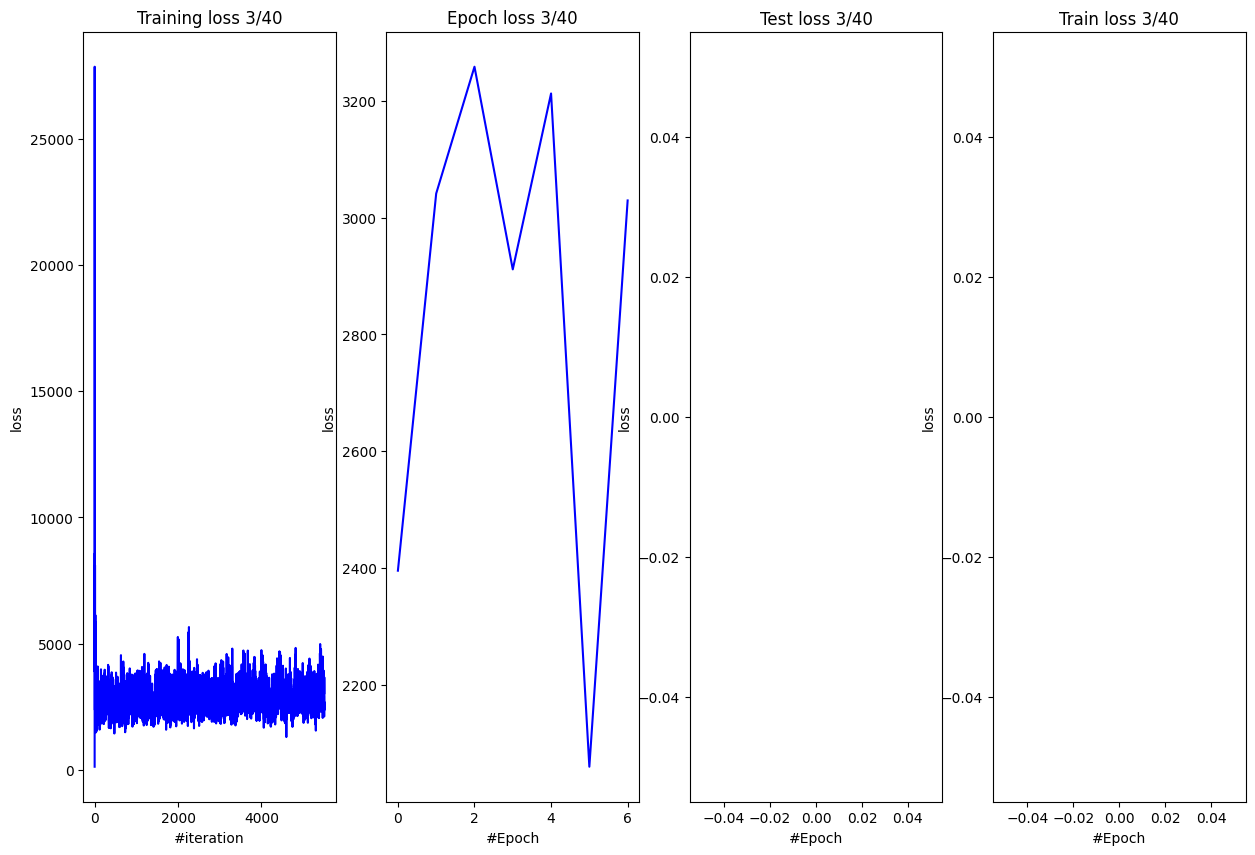

1/40 current loss: 2395.709228515625
2/40 current loss: 3041.259765625
3/40 current loss: 3258.307373046875
4/40 current loss: 2911.421875
5/40 current loss: 3212.497802734375
6/40 current loss: 2060.185302734375
7/40 current loss: 3029.422607421875


KeyboardInterrupt: 

In [ ]:
calculate_train_mae = True
train_mae = []
test_mae = []
for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)
        
        loss = criterion(predictions, y_batch)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad() 

        loss_history.append(loss.item())
    epoch_loss_history.append(loss.item())
    fig, axs = None, None
    if calculate_train_mae:
        fig, axs = plt.subplots(nrows= 1, ncols= 4,  figsize=(15,10))
    else:
        fig, axs = plt.subplots(nrows= 1, ncols= 3,  figsize=(15,10))
    display.clear_output(wait=True)

    axs[0].set_title(f"Training loss {i+1}/{num_epochs}")
    axs[0].set_xlabel("#iteration")
    axs[0].set_ylabel("loss")
    axs[0].plot(loss_history, 'b')
    
    axs[1].set_title(f"Epoch loss {i+1}/{num_epochs}")
    axs[1].set_xlabel("#Epoch")
    axs[1].set_ylabel("loss")
    axs[1].plot(epoch_loss_history, 'b')

    test_mae.append(metrics.mae(test_dataloader_out, model))
    print(test_mae)
    axs[2].set_title(f"Test loss {i+1}/{num_epochs}")
    axs[2].set_xlabel("#Epoch")
    axs[2].set_ylabel("loss")
    axs[2].plot(test_mae, 'b')

    if calculate_train_mae:
        train_mae.append(metrics.mae(train_dataloader_out, model))

        axs[3].set_title(f"Train loss {i+1}/{num_epochs}")
        axs[3].set_xlabel("#Epoch")
        axs[3].set_ylabel("loss")
        axs[3].plot(train_mae, 'b')

    plt.show()

    for i in range(len(epoch_loss_history)):
        print(f'{i+1}/{num_epochs} current loss: {epoch_loss_history[i]}') 
torch.save(model.state_dict, 'weights/CatNet.pth')

In [ ]:
model = CatNet(16, 18)
model.load_state_dict(torch.load('weights/CatNet.pth')())
model.eval()
""

''

## Оценка

In [ ]:
print(f"MAE on train data : {metrics.mae(train_dataloader_out, model)}")
print(f"MAE on test data : {metrics.mae(test_dataloader_out, model)}")

1
MAE on train data : 11.599783164608793


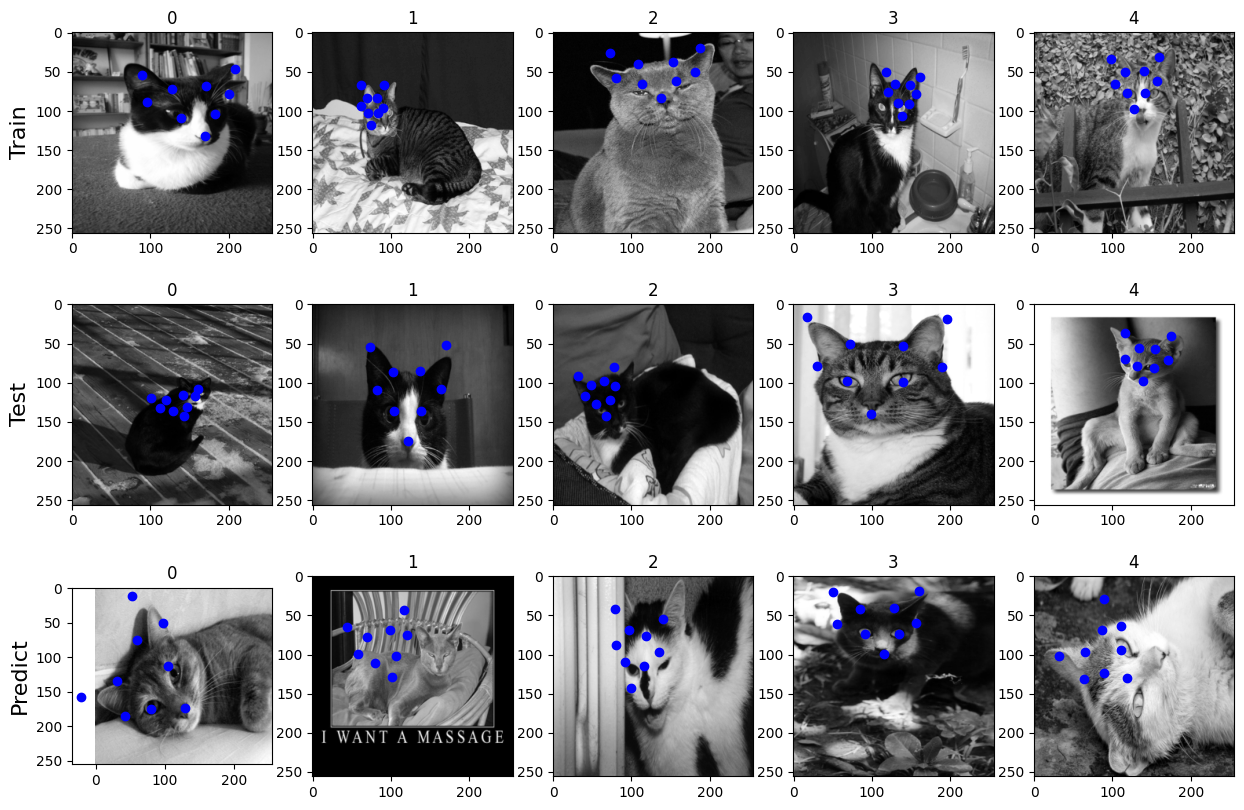

In [ ]:
fig, axs = plt.subplots(nrows= 3 , ncols= 5,  figsize=(15,10))
drawing.draw_pred_line(axs, train_dataset, model, 'Train', 0, 5)
drawing.draw_pred_line(axs, test_dataset, model, 'Test', 1, 5)
drawing.draw_pred_line(axs, result_dataset, model, 'Predict', 2, 5)

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

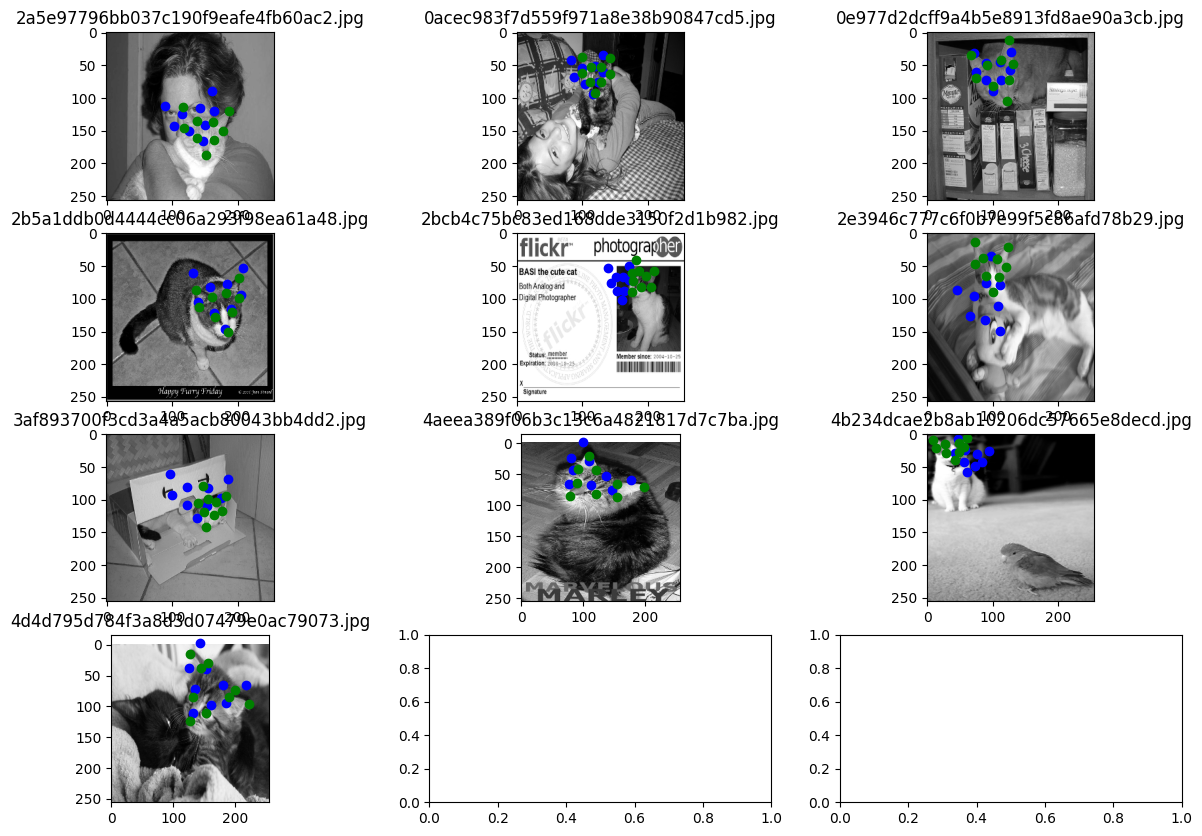

In [ ]:
#from pythonUtils.drawing import draw_img_by_name
from pythonUtils.config import intresting_pictures
fig, axs = plt.subplots(nrows= (len(intresting_pictures)//3)+1, ncols= 3,  figsize=(15,10))

for i in range(len(intresting_pictures)):
    drawing.draw_img_by_name(intresting_pictures[i], model, axs[i//3,i%3])

## Подсчет результатов

In [ ]:
pred = []
for x in result_dataloader_1:
    preds = model.forward(x[0])
    pred.append(preds[0].tolist())
predSizesNames = pd.read_csv('datasets/predictSizez&names.csv')

In [ ]:
columns = pd.read_csv('train_labels.csv').columns
result = pd.DataFrame(columns=columns)
for row in range(len(pred)):
    width = predSizesNames.loc[row,'0']
    height = predSizesNames.loc[row,'0']
    for i in range(0, len(pred[row]),2):
            pred[row][i] = pred[row][i]*(width/size)
            pred[row][i+1] = pred[row][i+1]*(height/size)
for row in range(len(pred)):
    result.loc[-1] = pred[row]+[predSizesNames.loc[row,'2']]
    result.index = result.index + 1
    result = result.sort_index()
result = result.rename(columns={"file_name":"file_names"})
result.to_csv('results/result.csv',index=False)